In [1]:
import jsonlines
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from IPython.display import set_matplotlib_formats
import torch
from tqdm import tqdm
import pandas as pd
import statistics
from transformers import AutoTokenizer, AutoModel

### Fig 4

In [2]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [3]:
filename = "generated_data/nli_data_with_similarity_scores.csv"
df = pd.read_csv(filename)
df.head()

,sent0,sent1,hard_neg,pos_score,neg_score
0,you know during the season and i guess at at y...,You lose the things to the following level if ...,They never perform recalls on anything.,0.28,0.00
1,One of our number will carry out your instruct...,A member of my team will execute your orders w...,We have no one free at the moment so you have ...,0.70,0.38
2,How do you know? All this is their information...,This information belongs to them.,They have no information at all.,0.35,0.25
3,yeah i tell you what though if you go price so...,The tennis shoes can be in the hundred dollar ...,The tennis shoes are not over hundred dollars.,0.72,0.37
4,my walkman broke so i'm upset now i just have ...,I'm upset that my walkman broke and now I have...,My walkman still works as well as it always did.,0.91,0.45


In [4]:
sent0s = df['sent0']
sent1s = df['sent1']
hard_negs = df['hard_neg']

In [5]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [7]:
model_path = "result_CLAIF/clhaif-bert-base-smoothall"
tokenizer_path = model_path
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
model = AutoModel.from_pretrained(model_path)
model.to(device)

Some weights of the model checkpoint at result_CLAIF/clhaif-bert-base-smoothall were not used when initializing BertModel: ['proxies', 'mlp.dense.weight', 'mlp.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [8]:
orig_scores1 = []
orig_scores2 = []
orig_scores3 = []

for i in tqdm(range(df.shape[0])): # tqdm(range(256))
    texts = [sent0s[i], sent0s[i], hard_negs[i]]
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
            embeddings = model(**inputs, output_hidden_states=True, return_dict=True).pooler_output
    embeddings = embeddings.detach().cpu()
    
    orig_scores1.append(cosine(embeddings[0], embeddings[1]))
    orig_scores2.append(cosine(embeddings[0], embeddings[2]))
    orig_scores3.append(cosine(embeddings[1], embeddings[2]))
    
sum(orig_scores1)/len(orig_scores1)

100%|████████████████████████████████████████████████████████████| 275601/275601 [24:18<00:00, 188.94it/s]


1.0000000043139678

In [9]:
model_path = "result_CLAIF/clhaif-bert-base-smoothall_lastterm" 
tokenizer_path = model_path
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
model = AutoModel.from_pretrained(model_path)
model.to(device)

Some weights of the model checkpoint at result_CLAIF/clhaif-bert-base-smoothall_lastterm were not used when initializing BertModel: ['proxies']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [10]:
scores1 = []
scores2 = []
scores3 = []

for i in tqdm(range(df.shape[0])): # tqdm(range(256))
    texts = [sent0s[i], sent1s[i], hard_negs[i]]
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
            embeddings = model(**inputs, output_hidden_states=True, return_dict=True).pooler_output
    embeddings = embeddings.detach().cpu()
    
    scores1.append(cosine(embeddings[0], embeddings[1]))
    scores2.append(cosine(embeddings[0], embeddings[2]))
    scores3.append(cosine(embeddings[1], embeddings[2]))
    
sum(scores1)/len(scores1)

100%|████████████████████████████████████████████████████████████| 275601/275601 [24:15<00:00, 189.37it/s]


0.816297975564047

In [11]:
sns.set_theme(style='darkgrid',
              rc={'xtick.bottom': True,
                  'ytick.left': True})
set_matplotlib_formats('retina')

/tmp/ipykernel_956756/590903462.py:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [12]:
model_name = 'CLHAIF' # CLHAIF

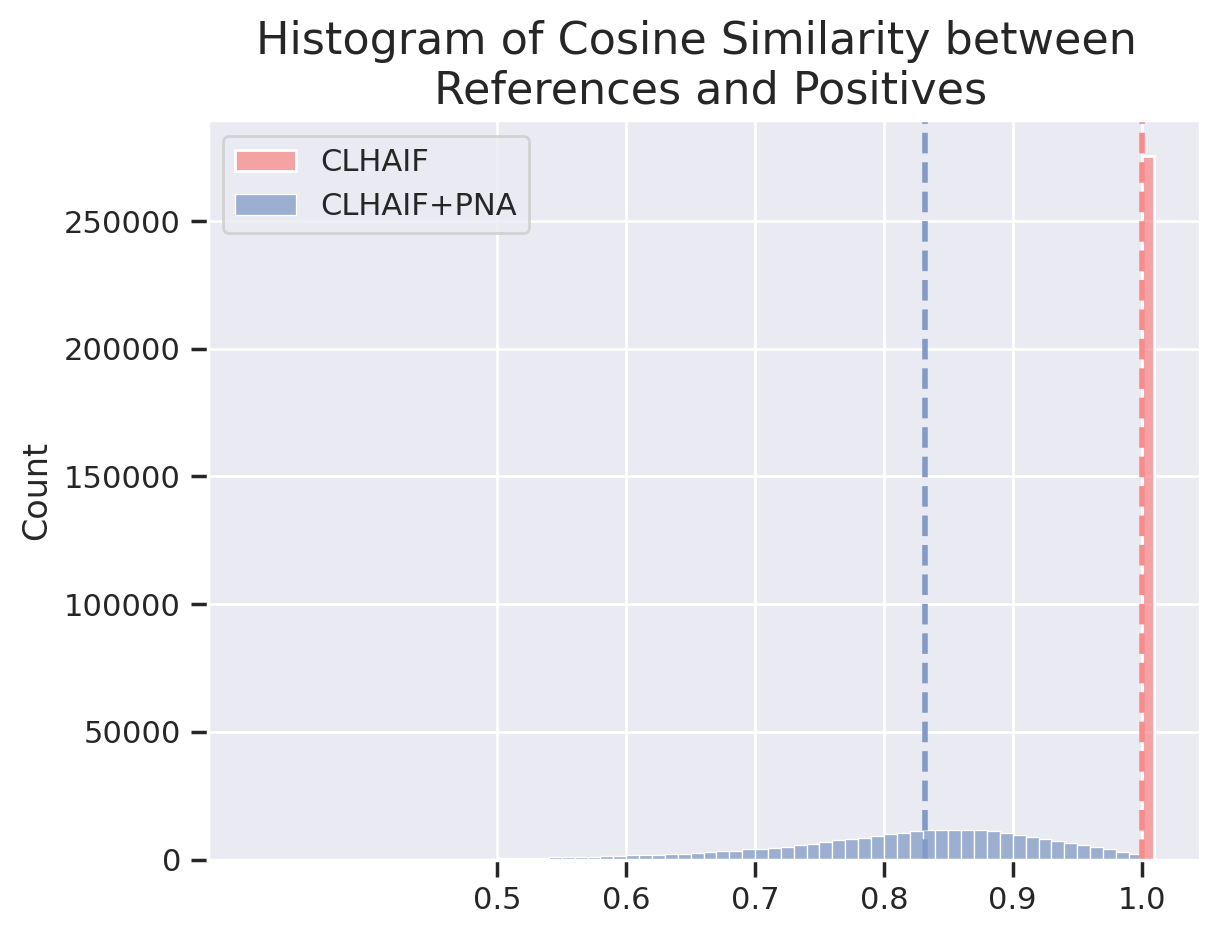

In [13]:
sns.histplot(orig_scores1, binwidth=0.01, label=f'{model_name}', color='#f88c8c')
sns.histplot(scores1, binwidth=0.01, label=f'{model_name}+PNA', color='#829bc6')
plt.axvline(x=statistics.median(orig_scores1), color='#f88c8c', ls='--', lw=2)
plt.axvline(x=statistics.median(scores1), color='#829bc6', ls='--', lw=2)
plt.xticks(np.arange(0.5, 1.01, 0.1))
plt.title("Histogram of Cosine Similarity between \n References and Positives", fontsize=16)
plt.legend()
plt.savefig('fig1.pdf')
plt.show()

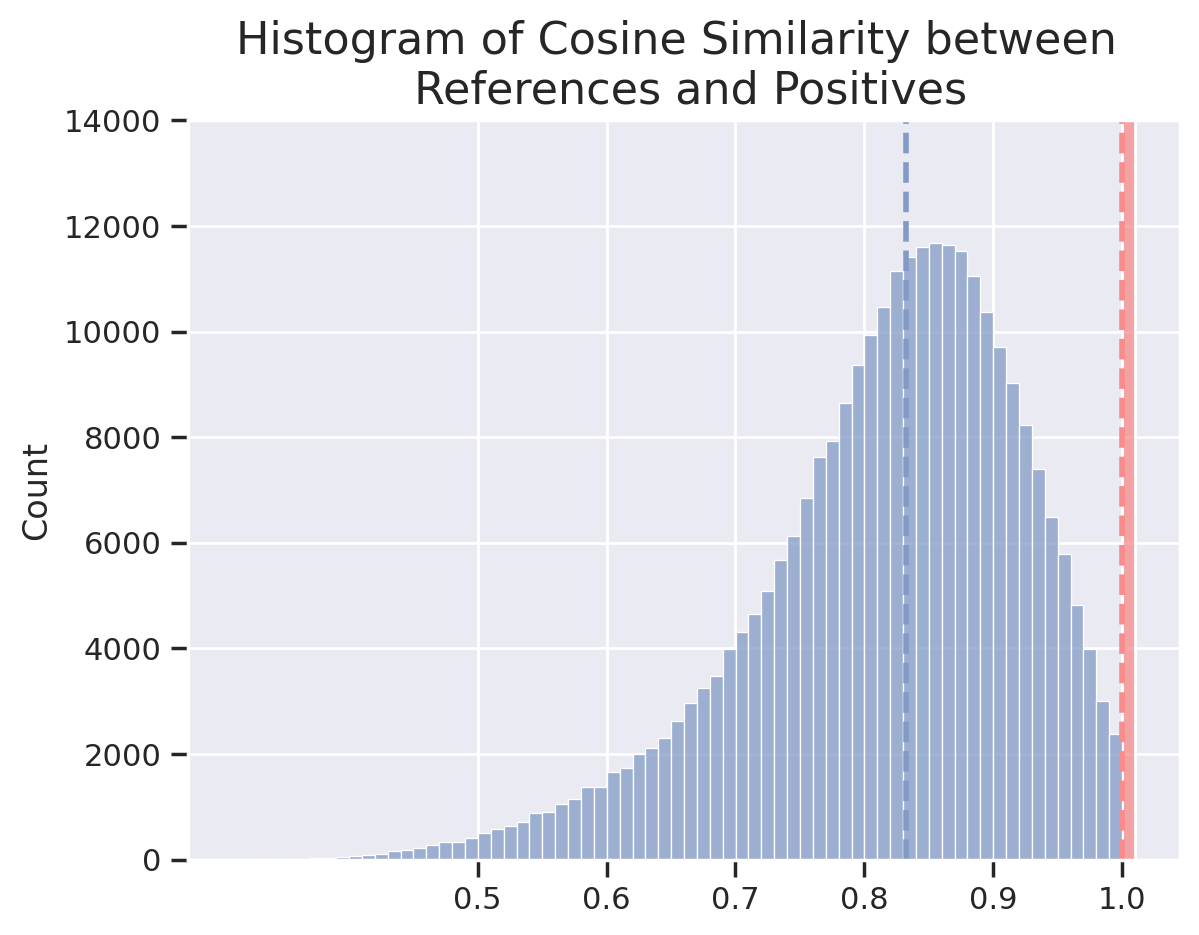

In [19]:
sns.histplot(orig_scores1, binwidth=0.01, label=f'{model_name}', color='#f88c8c')
sns.histplot(scores1, binwidth=0.01, label=f'{model_name}+PNA', color='#829bc6')
plt.axvline(x=statistics.median(orig_scores1), color='#f88c8c', ls='--', lw=2)
plt.axvline(x=statistics.median(scores1), color='#829bc6', ls='--', lw=2)
plt.xticks(np.arange(0.5, 1.01, 0.1))
plt.ylim([0, 14000])
plt.title("Histogram of Cosine Similarity between \n References and Positives", fontsize=16)
plt.savefig('fig1_expand.pdf')
plt.show()

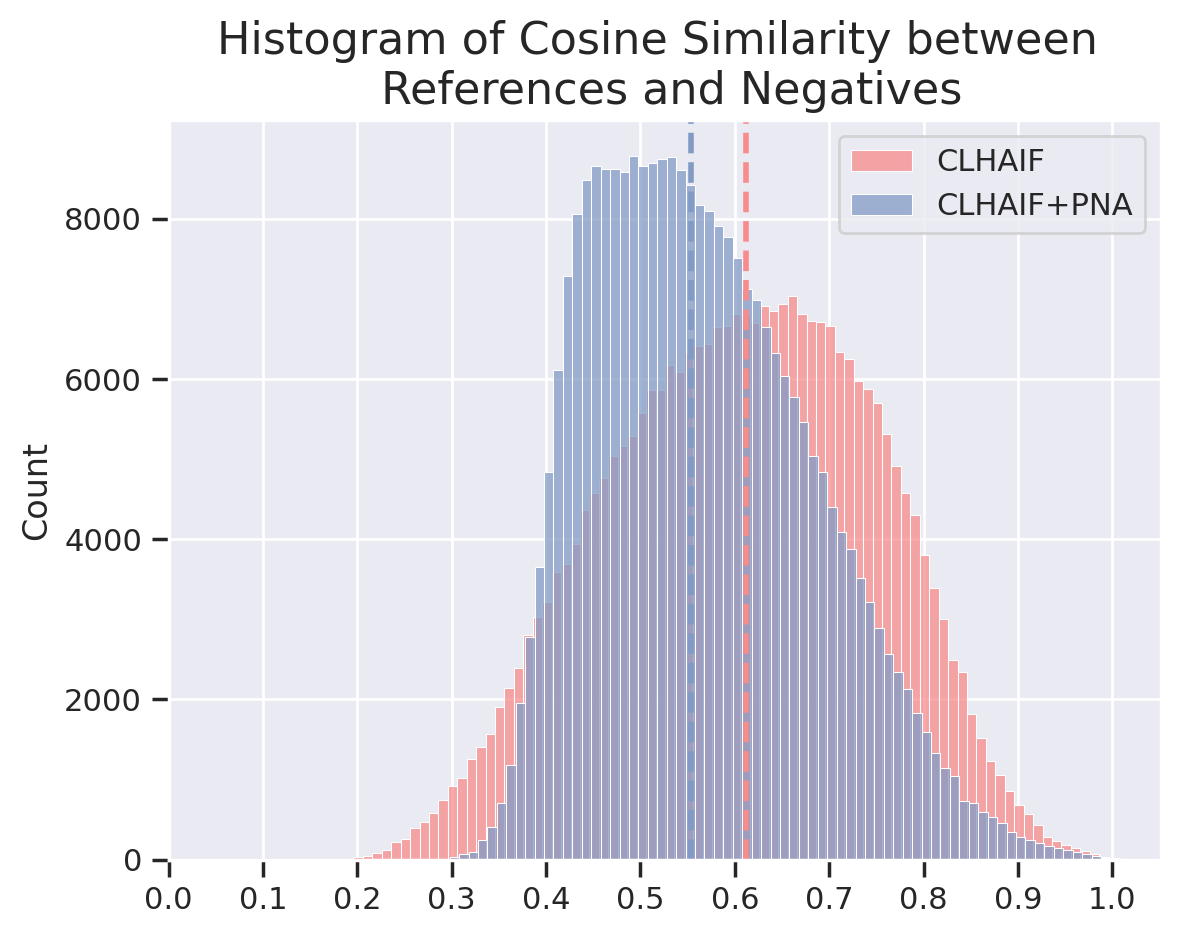

In [15]:
sns.histplot(orig_scores2, binwidth=0.01, label=f'{model_name}', color='#f88c8c')
sns.histplot(scores2, binwidth=0.01, label=f'{model_name}+PNA', color='#829bc6')
plt.axvline(x=statistics.median(orig_scores2), color='#f88c8c', ls='--', lw=2)
plt.axvline(x=statistics.median(scores2), color='#829bc6', ls='--', lw=2)
plt.xticks(np.arange(0.0, 1.1, 0.1))
plt.title("Histogram of Cosine Similarity between \n References and Negatives", fontsize=16)
plt.legend()
plt.savefig('fig2.pdf')
plt.show()

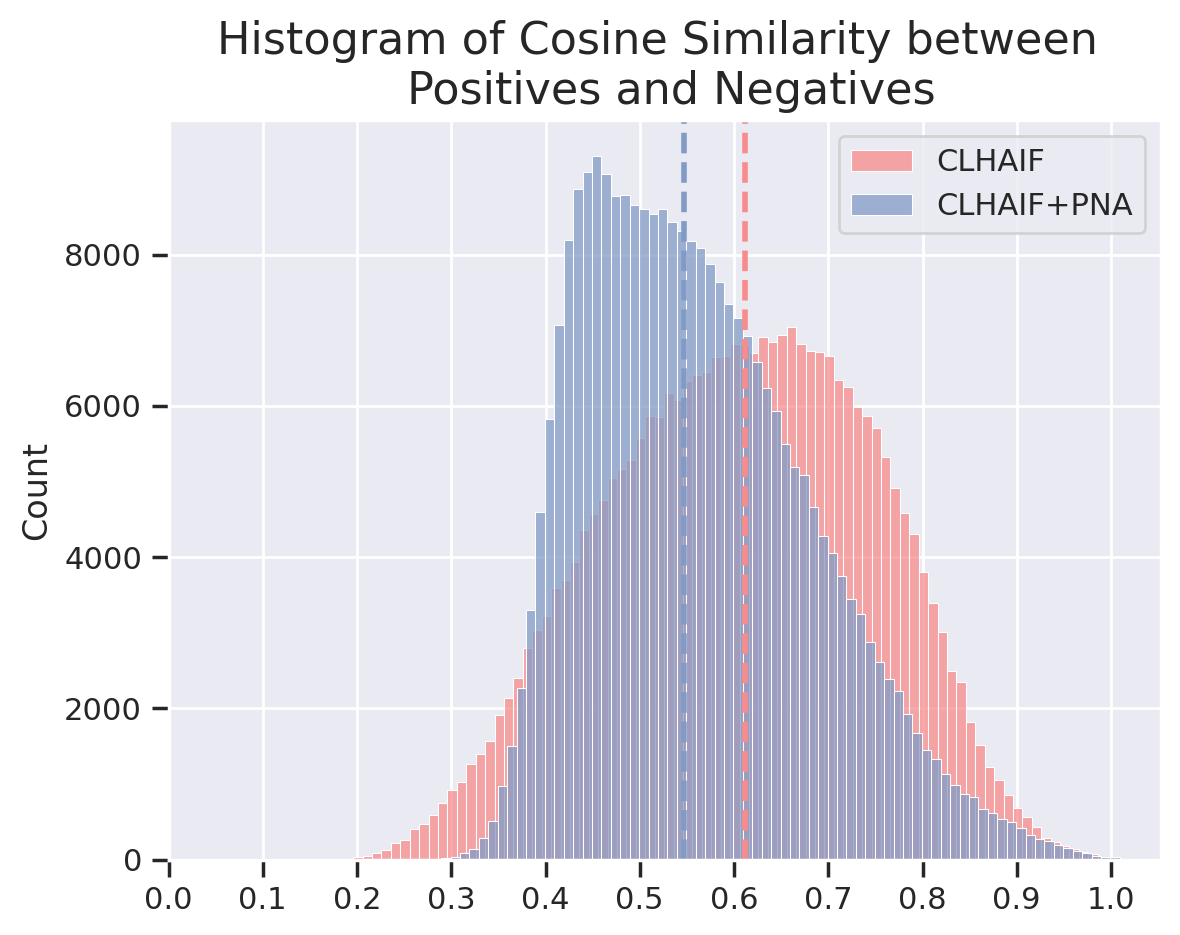

In [16]:
sns.histplot(orig_scores3, binwidth=0.01, label=f'{model_name}', color='#f88c8c')
sns.histplot(scores3, binwidth=0.01, label=f'{model_name}+PNA', color='#829bc6')
plt.axvline(x=statistics.median(orig_scores3), color='#f88c8c', ls='--', lw=2)
plt.axvline(x=statistics.median(scores3), color='#829bc6', ls='--', lw=2)
plt.xticks(np.arange(0.0, 1.1, 0.1))
plt.title("Histogram of Cosine Similarity between \n Positives and Negatives", fontsize=16)
plt.legend()
plt.savefig('fig3.pdf')
plt.show()